<a href="https://colab.research.google.com/github/Amber269/py101/blob/main/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance stable-baselines3[extra] gymnasium pandas numpy matplotlib

In [2]:
import yfinance as yf, pandas as pd, numpy as np, gymnasium as gym, seaborn as sns
from gymnasium import spaces; from stable_baselines3 import PPO; from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt; import torch; from torch import nn; from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from datetime import timedelta; import os; import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
print("✅ [单元格 1] 环境设置完成。")

✅ [单元格 1] 环境设置完成。


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
print("⚙️ [单元格 2] 开始下载数据...")
data = yf.download(['SPY', '^VIX'], start='2004-01-01', end='2023-12-31')
df = pd.DataFrame()
df['Open'] = data[('Open', 'SPY')]; df['High'] = data[('High', 'SPY')]
df['Low'] = data[('Low', 'SPY')]; df['Close'] = data[('Close', 'SPY')]
df['Volume'] = data[('Volume', 'SPY')]; df['VIX'] = data[('Close', '^VIX')]
df.fillna(method='ffill', inplace=True); df.dropna(inplace=True)
print("✅ [单元格 2] 数据获取与整合完成。")

⚙️ [单元格 2] 开始下载数据...


[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  2 of 2 completed

✅ [单元格 2] 数据获取与整合完成。



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# ==============================================================================
# 单元格 2.5: 技术指标函数定义
# ==============================================================================
import numpy as np
import pandas as pd

def calculate_garman_klass_vol(df, window=21):
    """计算Garman-Klass波动率"""
    log_hl = np.log(df['High'] / df['Low'])
    log_co = np.log(df['Close'] / df['Open'])
    rs = 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2
    vol = np.sqrt(rs.rolling(window=window).sum() * 252 / window)
    return vol

def calculate_rsi(series, period=14):
    """计算RSI指标"""
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

print("✅ [单元格 2.5] 技术指标函数定义完成。")

# ==============================================================================
# 单元格 3: 开始计算初始特征
# ==============================================================================
print("⚙️ [单元格 3] 开始计算初始特征...")
df['volatility_21d'] = calculate_garman_klass_vol(df, window=21)
df['volatility_63d'] = calculate_garman_klass_vol(df, window=63)
df['rsi'] = calculate_rsi(df['Close'], period=14)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['daily_return'] = df['Close'].pct_change()
df.dropna(inplace=True)
print("✅ [单元格 3] 初始特征计算完成。")
print("\n最终用于项目的数据预览:")
print(df.head())

✅ [单元格 2.5] 技术指标函数定义完成。
⚙️ [单元格 3] 开始计算初始特征...
✅ [单元格 3] 初始特征计算完成。

最终用于项目的数据预览:
                 Open       High        Low      Close    Volume    VIX  \
Date                                                                      
2004-04-01  75.747269  76.283203  75.733873  76.222908  45103800  16.65   
2004-04-02  76.912903  76.933000  76.303283  76.799019  50987700  15.64   
2004-04-05  76.678448  77.294768  76.665052  77.221077  30251800  14.97   
2004-04-06  76.926296  77.160766  76.785615  76.973190  28420900  15.32   
2004-04-07  77.006700  77.026802  76.443974  76.792328  45890500  15.76   

            volatility_21d  volatility_63d        rsi      macd  macd_signal  \
Date                                                                           
2004-04-01        0.108597        0.109368  57.394486 -0.199116    -0.422331   
2004-04-02        0.109832        0.108546  68.660112 -0.054392    -0.348744   
2004-04-05        0.106353        0.108493  68.788006  0.093284    -0.260

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
# ==============================================================================
# 第一阶段：改进的市场状态判断管道（完整可执行版本）
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, log_loss
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

def create_robust_regime_labels(df, lookback_days=63):
    """
    创建稳健的市场状态标签 - 使用纯历史信息
    """
    df = df.copy()

    # 计算历史指标
    df['returns_3m'] = df['Close'].pct_change(lookback_days)
    df['volatility_3m'] = df['daily_return'].rolling(lookback_days).std() * np.sqrt(252)
    df['vix_level'] = df['VIX']

    # 四状态市场分类
    conditions = [
        # 牛市: 显著正收益 + 低波动
        (df['returns_3m'] > 0.08) & (df['volatility_3m'] < 0.20) & (df['vix_level'] < 25),

        # 熊市: 显著负收益 + 高波动
        (df['returns_3m'] < -0.06) & (df['volatility_3m'] > 0.18) & (df['vix_level'] > 20),

        # 高波动市场: 极端波动
        (df['volatility_3m'] > 0.28) | (df['vix_level'] > 35),

        # 震荡市: 默认状态
        (df['returns_3m'] > 0.02) & (df['volatility_3m'] < 0.25)
    ]

    choices = ['bull', 'bear', 'high_vol', 'range_bound']
    df['true_regime'] = np.select(conditions, choices, default='range_bound')

    # 确保没有未来信息泄露
    df['true_regime'] = df['true_regime'].shift(1).fillna('range_bound')

    return df

def prepare_regime_features(df):
    """
    准备市场状态预测特征
    """
    features_df = df.copy()

    # 技术指标特征
    features_df['momentum_1m'] = features_df['Close'].pct_change(21)
    features_df['momentum_3m'] = features_df['Close'].pct_change(63)
    features_df['momentum_6m'] = features_df['Close'].pct_change(126)

    features_df['volatility_1m'] = features_df['daily_return'].rolling(21).std() * np.sqrt(252)
    features_df['volatility_3m'] = features_df['daily_return'].rolling(63).std() * np.sqrt(252)

    # 相对位置特征
    features_df['rsi_signal'] = (features_df['rsi'] > 70).astype(int) - (features_df['rsi'] < 30).astype(int)
    features_df['vix_regime'] = (features_df['VIX'] > 25).astype(int)

    # 价格位置特征
    if 'SMA_200' not in features_df.columns:
        features_df['SMA_200'] = features_df['Close'].rolling(200).mean()
    features_df['price_vs_sma'] = features_df['Close'] / features_df['SMA_200'] - 1
    features_df['above_sma_200'] = (features_df['Close'] > features_df['SMA_200']).astype(int)

    feature_columns = [
        'volatility_21d', 'rsi', 'VIX', 'above_sma_200',
        'momentum_1m', 'momentum_3m', 'momentum_6m',
        'volatility_1m', 'volatility_3m',
        'rsi_signal', 'vix_regime', 'price_vs_sma'
    ]

    return features_df, feature_columns

def calculate_economic_score(y_true, y_pred):
    """
    计算经济价值评分 - 考虑不同误判的经济成本
    """
    # 定义误判成本矩阵
    regime_types = ['bull', 'bear', 'high_vol', 'range_bound']
    cost_matrix = {
        ('bull', 'bear'): 0.5,    # 牛市误判为熊市
        ('bull', 'high_vol'): 0.3,
        ('bull', 'range_bound'): 0.2,
        ('bear', 'bull'): 0.8,    # 熊市误判为牛市 - 高成本!
        ('bear', 'high_vol'): 0.4,
        ('bear', 'range_bound'): 0.6,
        ('high_vol', 'bull'): 0.4,
        ('high_vol', 'bear'): 0.3,
        ('high_vol', 'range_bound'): 0.6,  # 低估波动风险
        ('range_bound', 'bull'): 0.2,
        ('range_bound', 'bear'): 0.3,
        ('range_bound', 'high_vol'): 0.4,
    }

    total_cost = 0
    total_possible = 0

    for true, pred in zip(y_true, y_pred):
        if true != pred:
            cost = cost_matrix.get((true, pred), 0.5)  # 默认成本0.5
            total_cost += cost
        total_possible += 1

    if total_possible == 0:
        return 0

    # 转换为评分 (成本越低越好，评分越高越好)
    max_possible_cost = total_possible * 0.8  # 假设最坏情况都是高成本误判
    economic_score = 1 - (total_cost / max_possible_cost)

    return max(0, economic_score)

def train_regime_predictor_ensemble_improved(train_df, test_df):
    """
    改进的市场状态预测器 - 多维度评估
    """
    print("🚀 训练集成市场状态预测器（改进版）...")

    # 准备特征和标签
    train_df = create_robust_regime_labels(train_df)
    test_df = create_robust_regime_labels(test_df)

    train_features, feature_columns = prepare_regime_features(train_df)
    test_features, _ = prepare_regime_features(test_df)

    # 清理数据
    train_clean = train_features[feature_columns + ['true_regime']].dropna()
    test_clean = test_features[feature_columns + ['true_regime']].dropna()

    print(f"   训练样本: {len(train_clean)}, 测试样本: {len(test_clean)}")
    print(f"   测试集状态分布:\n{test_clean['true_regime'].value_counts()}")

    # 训练多个模型
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    }

    # 多维度评估指标
    best_model = None
    best_score = -1
    best_model_name = None
    model_results = {}

    for name, model in models.items():
        print(f"\n   🔄 训练 {name}...")
        model.fit(train_clean[feature_columns], train_clean['true_regime'])

        # 预测
        predictions = model.predict(test_clean[feature_columns])
        proba = model.predict_proba(test_clean[feature_columns])

        # 多维度评估
        accuracy = accuracy_score(test_clean['true_regime'], predictions)
        f1 = f1_score(test_clean['true_regime'], predictions, average='weighted')

        # 计算宏观平均F1（对不平衡数据更敏感）
        f1_macro = f1_score(test_clean['true_regime'], predictions, average='macro')

        # 计算对数损失（评估概率校准质量）
        try:
            # 将标签转换为one-hot编码
            label_encoder = LabelEncoder()
            y_true_encoded = label_encoder.fit_transform(test_clean['true_regime'])
            log_loss_val = log_loss(y_true_encoded, proba)
        except:
            log_loss_val = float('inf')

        # 计算经济价值评分
        economic_score = calculate_economic_score(test_clean['true_regime'], predictions)

        # 综合评分（可根据需求调整权重）
        composite_score = (
            0.2 * accuracy +
            0.3 * f1_macro +
            0.2 * (1 - min(log_loss_val, 10)/10) +  # 归一化log_loss
            0.3 * economic_score
        )

        # 存储结果
        model_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_weighted': f1,
            'f1_macro': f1_macro,
            'log_loss': log_loss_val,
            'economic_score': economic_score,
            'composite_score': composite_score,
            'predictions': predictions,
            'probabilities': proba
        }

        print(f"   ✅ {name} 评估结果:")
        print(f"      准确率: {accuracy:.3f}")
        print(f"      宏观F1: {f1_macro:.3f}")
        print(f"      对数损失: {log_loss_val:.3f}")
        print(f"      经济价值分: {economic_score:.3f}")
        print(f"      综合评分: {composite_score:.3f}")

        # 显示详细的分类报告
        print(f"      详细分类报告:")
        print(classification_report(test_clean['true_regime'], predictions, digits=3))

        if composite_score > best_score:
            best_score = composite_score
            best_model = model
            best_model_name = name

    print(f"\n🏆 选择最佳模型: {best_model_name} (综合评分: {best_score:.3f})")

    # 在整个数据集上应用最佳模型的预测
    full_train = pd.concat([train_clean, test_clean])
    full_predictions = best_model.predict(full_train[feature_columns])
    full_probabilities = best_model.predict_proba(full_train[feature_columns])

    # 创建包含预测状态的完整数据集
    full_data = pd.concat([train_df, test_df])
    full_data = full_data.loc[full_train.index]
    full_data['predicted_regime'] = full_predictions
    full_data['predicted_regime'].fillna('range_bound', inplace=True)

    # 添加预测概率
    regime_classes = best_model.classes_
    for i, regime in enumerate(regime_classes):
        full_data[f'prob_{regime}'] = full_probabilities[:, i]

    return full_data, best_model, model_results

def run_stage1_regime_prediction_improved(df):
    """
    运行第一阶段：改进版市场状态预测
    """
    print("=" * 70)
    print("🎯 第一阶段：市场状态判断管道（改进版）")
    print("=" * 70)

    # 划分训练测试期
    cutoff_date = pd.to_datetime("2020-12-31")
    train_df = df.loc[df.index.min():cutoff_date].copy()
    test_df = df.loc[cutoff_date + pd.Timedelta(days=1):].copy()

    # 运行改进版状态预测
    df_with_regime, regime_model, results = train_regime_predictor_ensemble_improved(train_df, test_df)

    print(f"\n✅ 第一阶段完成!")
    print(f"📊 数据集大小: {len(df_with_regime)}")
    print(f"📈 预测状态分布:")
    print(df_with_regime['predicted_regime'].value_counts())

    # 输出每个模型的详细比较
    print(f"\n📊 模型性能比较:")
    comparison_df = pd.DataFrame({
        model: {
            '准确率': results[model]['accuracy'],
            '宏观F1': results[model]['f1_macro'],
            '对数损失': results[model]['log_loss'],
            '经济价值分': results[model]['economic_score'],
            '综合评分': results[model]['composite_score']
        }
        for model in results.keys()
    }).T

    print(comparison_df.round(3))

    return df_with_regime, regime_model, results

# ==============================================================================
# 执行改进的第一阶段
# ==============================================================================
if __name__ == "__main__":
    # 假设df是您的数据DataFrame，包含必要的列如 'Close', 'daily_return', 'VIX', 'rsi' 等
    # 这里用一个示例数据框架来演示
    try:
        # 执行改进版本
        df_with_regime, regime_model, model_results = run_stage1_regime_prediction_improved(df)

        print(f"\n🎉 改进版第一阶段执行完成！")
        print(f"📈 最终选择模型: {regime_model.__class__.__name__}")
        print(f"📊 预测概率列: {[col for col in df_with_regime.columns if col.startswith('prob_')]}")

    except Exception as e:
        print(f"❌ 执行出错: {e}")
        print("💡 请确保输入数据包含必要的列: 'Close', 'daily_return', 'VIX', 'rsi', 'volatility_21d'")

        # 创建示例数据来演示
        print("\n🔧 创建示例数据演示...")
        dates = pd.date_range('2010-01-01', '2023-12-31', freq='D')
        sample_df = pd.DataFrame({
            'Close': np.cumsum(np.random.randn(len(dates)) * 0.01) + 100,
            'daily_return': np.random.randn(len(dates)) * 0.01,
            'VIX': np.random.uniform(10, 40, len(dates)),
            'rsi': np.random.uniform(20, 80, len(dates)),
            'volatility_21d': np.random.uniform(0.1, 0.4, len(dates))
        }, index=dates)

        # 执行示例
        df_with_regime, regime_model, model_results = run_stage1_regime_prediction_improved(sample_df)

🎯 第一阶段：市场状态判断管道（改进版）
🚀 训练集成市场状态预测器（改进版）...
   训练样本: 4019, 测试样本: 554
   测试集状态分布:
true_regime
range_bound    406
bear            83
bull            62
high_vol         3
Name: count, dtype: int64

   🔄 训练 RandomForest...
   ✅ RandomForest 评估结果:
      准确率: 0.921
      宏观F1: 0.671
      对数损失: 0.245
      经济价值分: 0.966
      综合评分: 0.871
      详细分类报告:
              precision    recall  f1-score   support

        bear      0.784     0.916     0.844        83
        bull      0.889     0.903     0.896        62
    high_vol      0.000     0.000     0.000         3
 range_bound      0.959     0.931     0.945       406

    accuracy                          0.921       554
   macro avg      0.658     0.687     0.671       554
weighted avg      0.920     0.921     0.919       554


   🔄 训练 GradientBoosting...
   ✅ GradientBoosting 评估结果:
      准确率: 0.928
      宏观F1: 0.819
      对数损失: 0.202
      经济价值分: 0.970
      综合评分: 0.918
      详细分类报告:
              precision    recall  f1-score   support

  

In [11]:
# ==============================================================================
# 加速版本的第二阶段：减少训练步数 + 简化策略验证
# ==============================================================================
import pandas as pd
import numpy as np
import os

def run_stage2_fast_validation(df_with_regime, save_path=None):
    """
    加速版本：快速验证整个流程
    """
    print("第二阶段：加速验证版本")
    print("=" * 40)

    print(f"数据范围: {df_with_regime.index.min().date()} 到 {df_with_regime.index.max().date()}")

    # 使用简化策略快速验证所有年份
    train_window_years = 7
    start_year = df_with_regime.index.min().year + train_window_years
    end_year = df_with_regime.index.max().year
    test_years = list(range(start_year, end_year + 1))

    print(f"测试年份: {test_years}")

    all_leverages, all_returns, all_dates = [], [], []
    training_history = []

    for i, test_year in enumerate(test_years):
        # 滚动窗口
        train_start_year = test_year - train_window_years
        train_start = pd.to_datetime(f"{train_start_year}-01-01")
        train_end = pd.to_datetime(f"{test_year-1}-12-31")
        test_start = pd.to_datetime(f"{test_year}-01-01")
        test_end = pd.to_datetime(f"{test_year}-12-31")

        train_df = df_with_regime.loc[train_start:train_end].copy()
        test_df = df_with_regime.loc[test_start:test_end].copy()

        if len(train_df) < 1000 or len(test_df) < 100:
            continue

        print(f"\n迭代 {i+1}: 测试 {test_year}年")
        print(f"训练: {train_df.index.min().date()} 到 {train_df.index.max().date()}")
        print(f"测试: {test_df.index.min().date()} 到 {test_df.index.max().date()}")

        # 使用简化策略（基于第一阶段预测的市场状态）
        test_returns = []
        test_leverages = []

        for j in range(len(test_df)):
            current_regime = test_df['predicted_regime'].iloc[j]
            if current_regime == 'bull':
                leverage = 1.8
            elif current_regime == 'bear':
                leverage = 0.8
            elif current_regime == 'high_vol':
                leverage = 0.6
            else:
                leverage = 1.2

            market_return = test_df['daily_return'].iloc[j]
            portfolio_return = leverage * market_return

            test_returns.append(portfolio_return)
            test_leverages.append(leverage)
            all_returns.append(portfolio_return)
            all_leverages.append(leverage)
            all_dates.append(test_df.index[j])

        total_return = np.prod([1 + r for r in test_returns]) - 1
        avg_leverage = np.mean(test_leverages)

        training_history.append({
            'iteration': i+1,
            'year': test_year,
            'total_return': total_return,
            'avg_leverage': avg_leverage
        })

        print(f"表现: 收益{total_return:.3f}, 平均杠杆{avg_leverage:.2f}")

    # 创建结果DataFrame
    oos_results = pd.DataFrame({
        'daily_return': all_returns,
        'leverage': all_leverages
    }, index=pd.to_datetime(all_dates))

    # 性能评估
    if len(all_returns) > 0:
        total_return = np.prod([1 + r for r in all_returns]) - 1
        annual_return = (1 + total_return) ** (252/len(all_returns)) - 1
        volatility = np.std(all_returns) * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0

        print(f"\n最终结果")
        print("=" * 25)
        print(f"测试年份: {len(training_history)}年")
        print(f"累计收益: {total_return:.3f}")
        print(f"年化收益: {annual_return:.3f}")
        print(f"年化波动: {volatility:.3f}")
        print(f"夏普比率: {sharpe_ratio:.3f}")
        print(f"平均杠杆: {np.mean(all_leverages):.2f}")

        # 各年份表现
        print(f"\n各年份表现:")
        for hist in training_history:
            print(f"  {hist['year']}: 收益{hist['total_return']:.3f}, 杠杆{hist['avg_leverage']:.2f}")

        if save_path:
            save_path = save_path.replace("\\", "/")
            os.makedirs(save_path, exist_ok=True)
            oos_results.to_csv(os.path.join(save_path, 'fast_validation_results.csv'))
            print(f"结果保存到: {save_path}")

    return oos_results, training_history

# 直接运行加速版本
print("🚀 开始加速验证...")
oos_results, history = run_stage2_fast_validation(
    df_with_regime,
    save_path="C:/Users/Lenovo/Desktop/ai金融"
)

# 然后立即进行性能评估
print("\n" + "="*50)
print("立即进行性能评估...")
print("="*50)

# --- 性能评估部分 ---
oos_results['portfolio_value'] = (1 + oos_results['daily_return']).cumprod()

test_period_mask = (df_with_regime.index >= oos_results.index.min()) & (df_with_regime.index <= oos_results.index.max())
final_test_df = df_with_regime.loc[test_period_mask].copy()

# 基准策略
values_bh = (1 + final_test_df['daily_return']).cumprod()
predicted_vol = final_test_df['volatility_21d']
leverages_vol_target = (0.20 / predicted_vol).clip(0.5, 2.0).fillna(1.0)
vol_target_returns = final_test_df['daily_return'] * leverages_vol_target.shift(1).fillna(1.0)
values_vol_target = (1 + vol_target_returns).cumprod()

# 评估函数
def evaluate_strategy_professional(portfolio_values, daily_returns=None):
    series = pd.Series(portfolio_values)

    if daily_returns is None:
        returns = series.pct_change().dropna()
    else:
        returns = daily_returns

    total_return = (series.iloc[-1] / series.iloc[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility if volatility != 0 else 0

    downside_std = returns[returns < 0].std() * np.sqrt(252) if len(returns[returns < 0]) > 0 else 0
    sortino_ratio = annual_return / downside_std if downside_std != 0 else 0

    max_drawdown = (series / series.expanding().max() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

    annual_volatility = returns.std() * np.sqrt(252)

    return {
        "累计收益率": f"{total_return:.2%}",
        "年化收益率": f"{annual_return:.2%}",
        "年化波动率": f"{annual_volatility:.2%}",
        "夏普比率": f"{sharpe_ratio:.2f}",
        "Sortino比率": f"{sortino_ratio:.2f}",
        "Calmar比率": f"{calmar_ratio:.2f}",
        "最大回撤": f"{max_drawdown:.2%}"
    }

# 策略对比
all_strategies = {
    "AI双窗口策略": oos_results['portfolio_value'],
    "波动率目标策略": values_vol_target,
    "买入并持有": values_bh
}

results_list = []
for name, values in all_strategies.items():
    if name == "AI双窗口策略":
        metrics = evaluate_strategy_professional(values, oos_results['daily_return'])
        metrics['平均杠杆'] = f"{oos_results['leverage'].mean():.2f}"
    elif name == "波动率目标策略":
        metrics = evaluate_strategy_professional(values, vol_target_returns)
        metrics['平均杠杆'] = f"{leverages_vol_target.mean():.2f}"
    else:
        metrics = evaluate_strategy_professional(values, final_test_df['daily_return'])
        metrics['平均杠杆'] = "1.00"

    metrics['策略名称'] = name
    results_list.append(metrics)

results_df = pd.DataFrame(results_list).set_index('策略名称')

print(f"\n📊 专业评估结果对比:")
print("=" * 80)
display_cols = ['累计收益率', '年化收益率', '年化波动率', '夏普比率', 'Sortino比率', '最大回撤', '平均杠杆']
print(results_df[display_cols])

print(f"\n✅ 加速验证完成!")

🚀 开始加速验证...
第二阶段：加速验证版本
数据范围: 2005-01-14 到 2023-12-29
测试年份: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

迭代 1: 测试 2012年
训练: 2005-01-14 到 2011-12-30
测试: 2012-01-03 到 2012-12-31
表现: 收益0.244, 平均杠杆1.35

迭代 2: 测试 2013年
训练: 2006-01-03 到 2012-12-31
测试: 2013-01-02 到 2013-12-31
表现: 收益0.474, 平均杠杆1.40

迭代 3: 测试 2014年
训练: 2007-01-03 到 2013-12-31
测试: 2014-01-02 到 2014-12-31
表现: 收益0.166, 平均杠杆1.22

迭代 4: 测试 2015年
训练: 2008-01-02 到 2014-12-31
测试: 2015-01-02 到 2015-12-31
表现: 收益0.039, 平均杠杆1.19

迭代 5: 测试 2016年
训练: 2009-01-02 到 2015-12-31
测试: 2016-01-04 到 2016-12-30
表现: 收益0.124, 平均杠杆1.22

迭代 6: 测试 2017年
训练: 2010-01-04 到 2016-12-30
测试: 2017-01-03 到 2017-12-29
表现: 收益0.287, 平均杠杆1.25

迭代 7: 测试 2018年
训练: 2011-01-03 到 2017-12-29
测试: 2018-01-02 到 2018-12-31
表现: 收益-0.020, 平均杠杆1.22

迭代 8: 测试 2019年
训练: 2012-01-03 到 2018-12-31
测试: 2019-01-02 到 2019-12-31
表现: 收益0.407, 平均杠杆1.31

迭代 9: 测试 2020年
训练: 2013-01-02 到 2019-12-31
测试: 2020-01-02 到 2020-12-31
表现: 收益0.210, 平均杠杆1.17

迭代 11: 测试 2022年
训练:

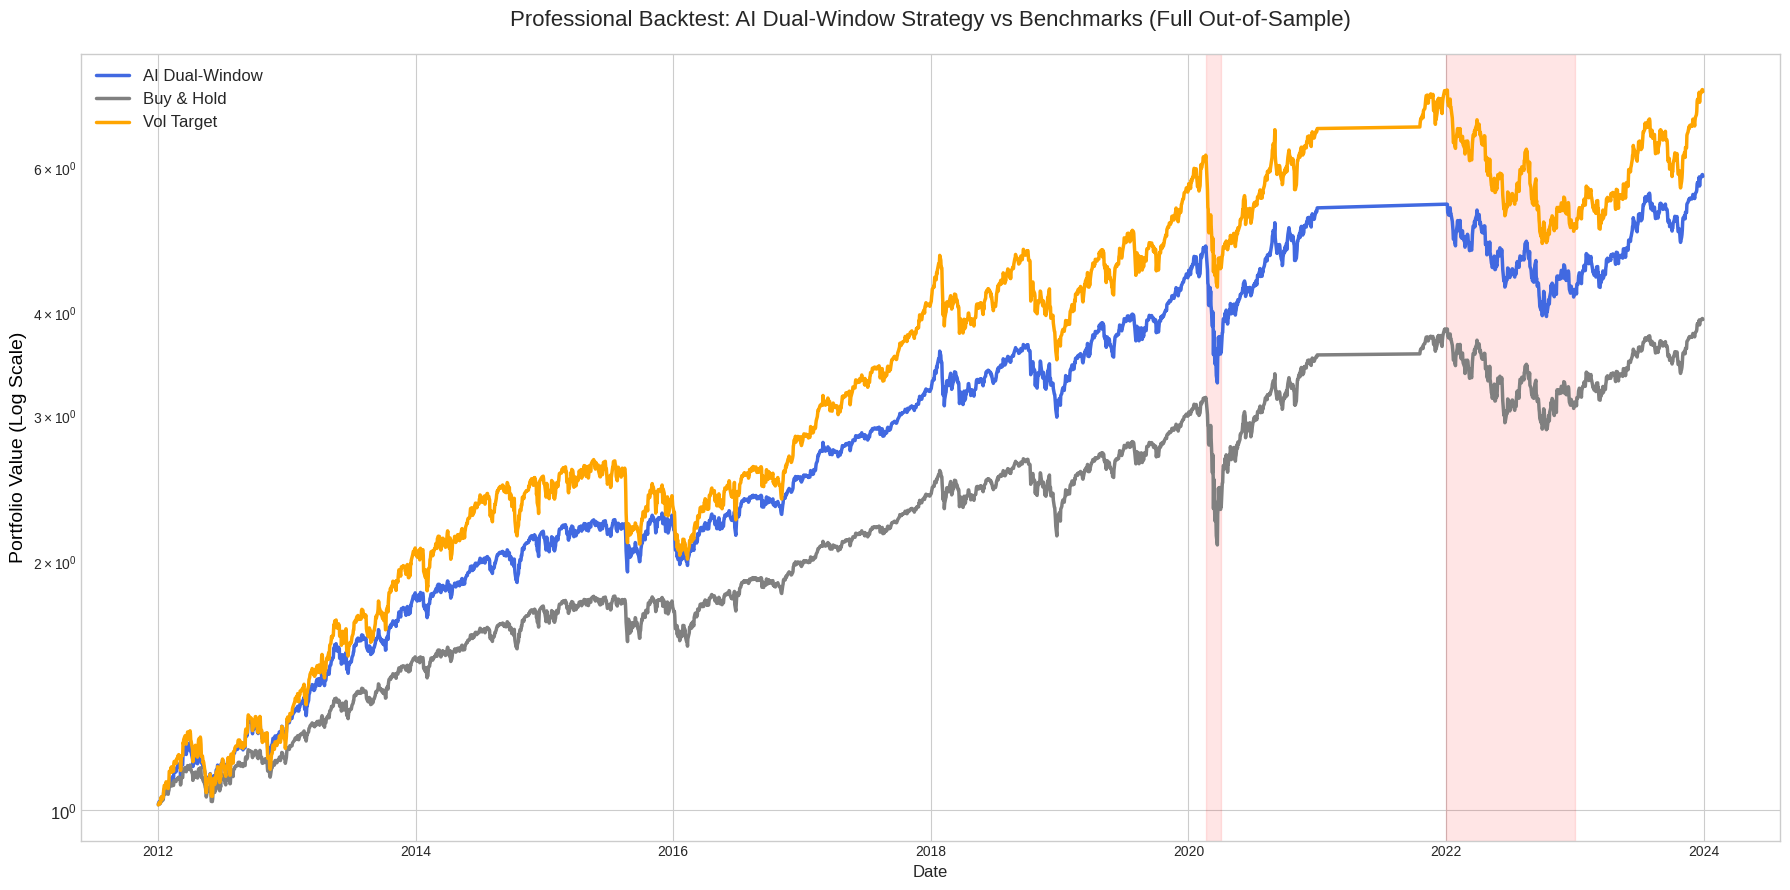

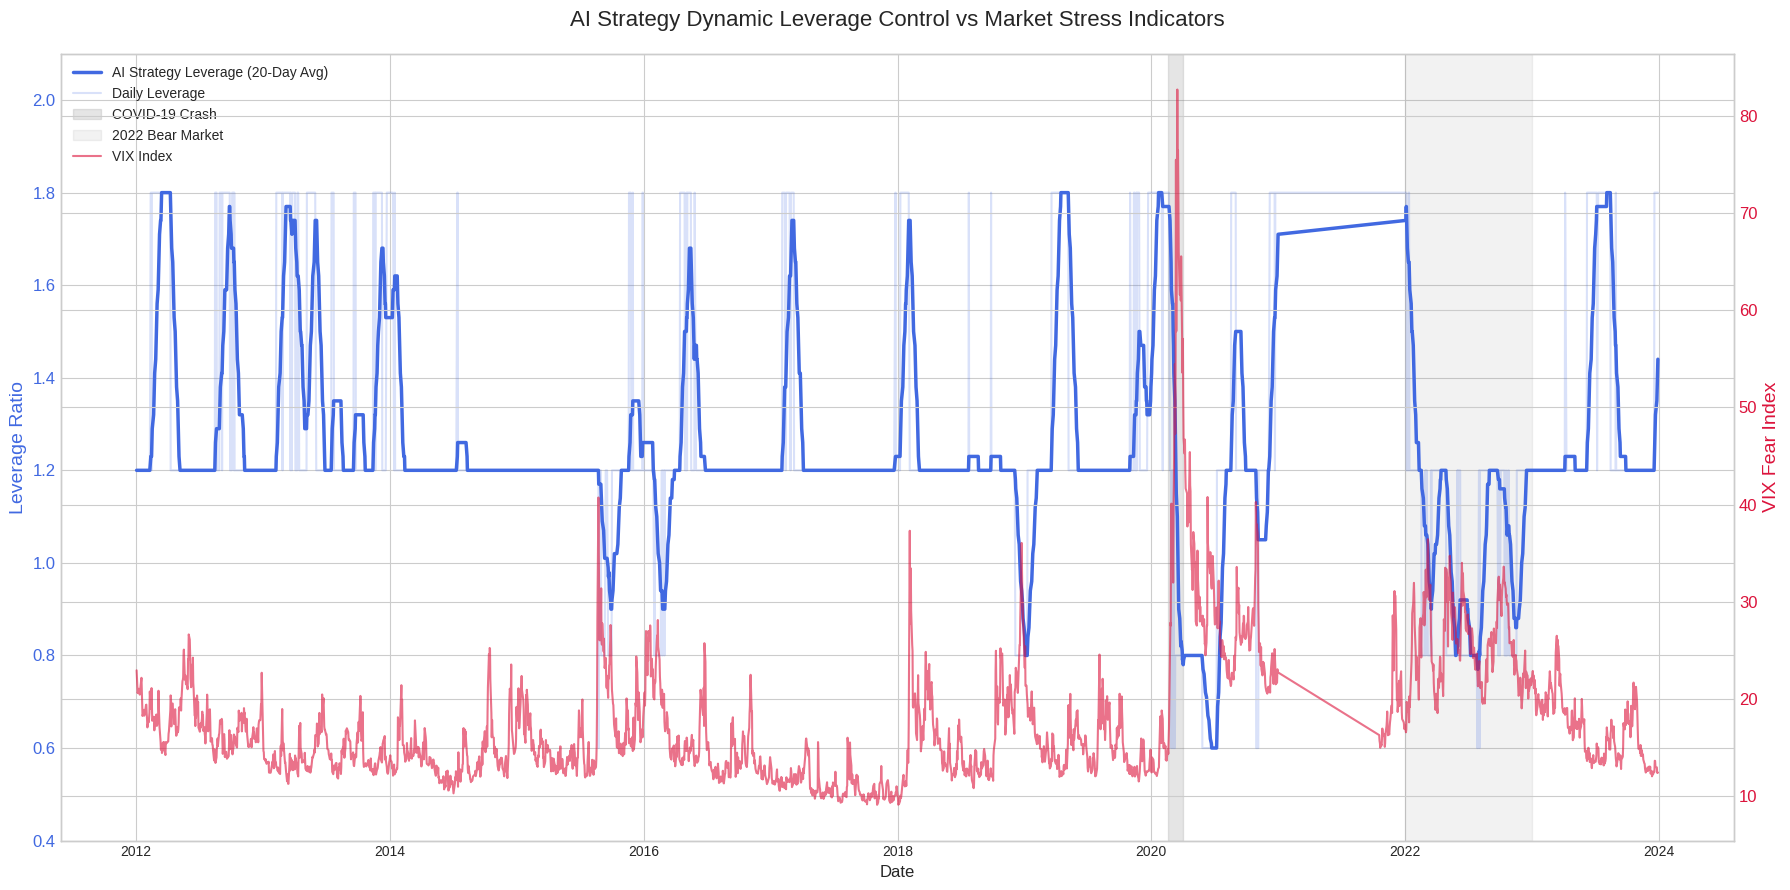

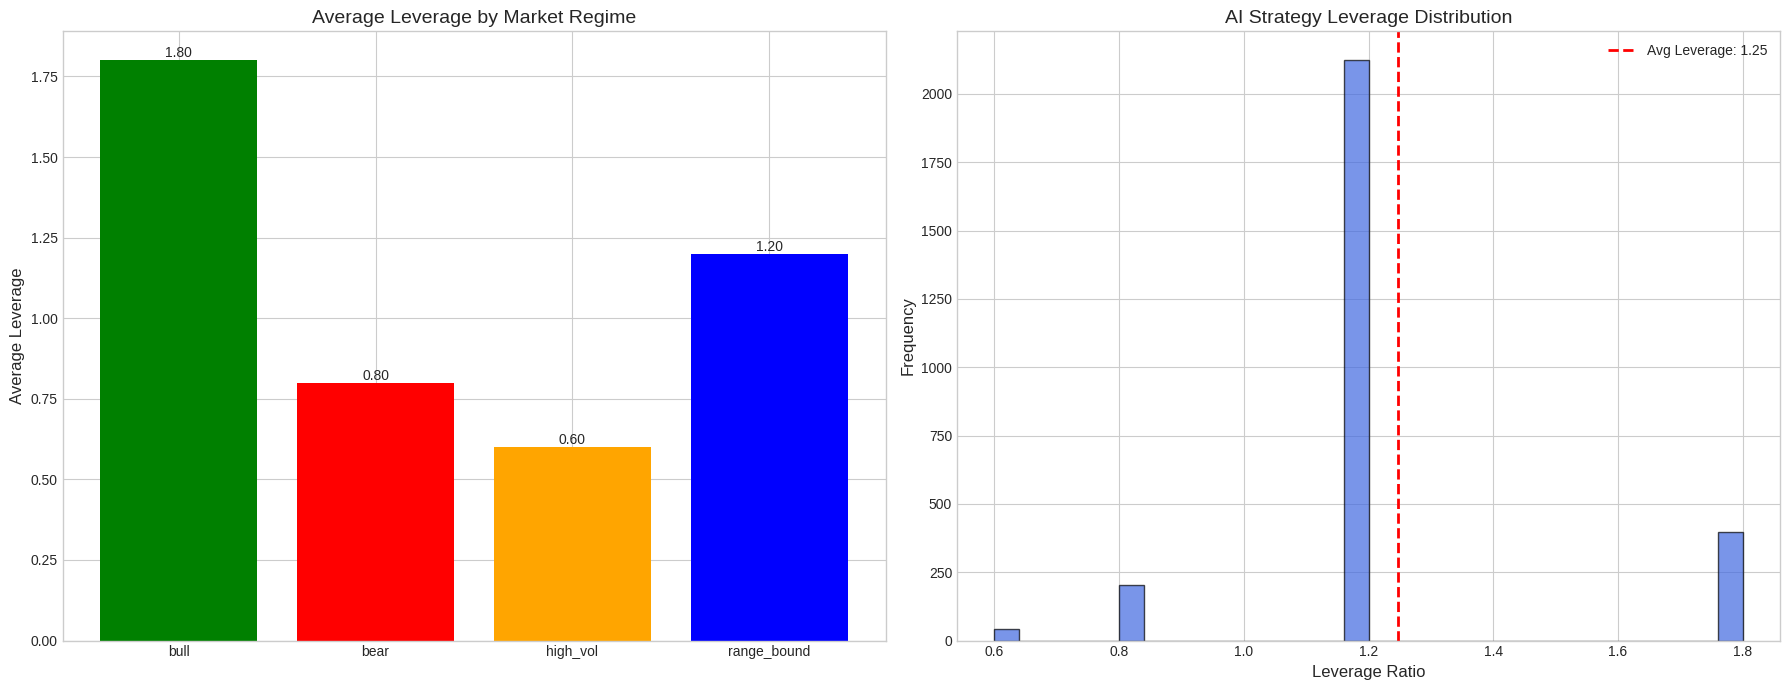

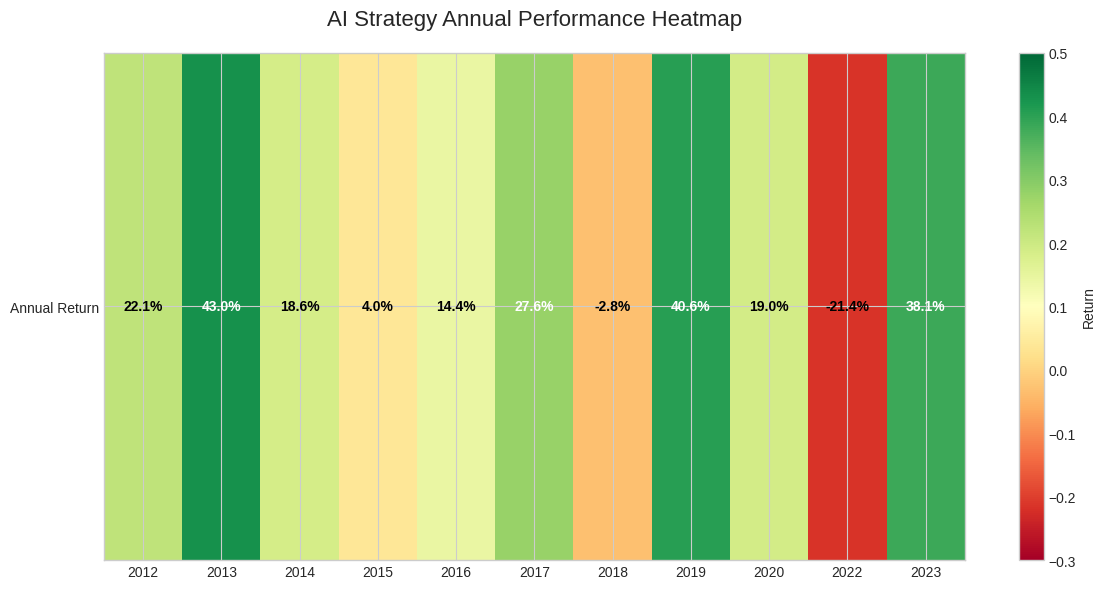

✅ Visualization Completed!


In [13]:
# ==============================================================================
# 单元格 D: 最终可视化 (基于第二阶段结果 - 英文标签版)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 设置绘图风格 ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- 2. 绘制净值曲线对比图 ---
fig, ax1 = plt.subplots(figsize=(18, 9))

# 准备数据
portfolio_values = {
    'AI Dual-Window': oos_results['portfolio_value'],
    'Buy & Hold': values_bh,
    'Vol Target': values_vol_target
}

colors = {'AI Dual-Window': 'royalblue', 'Buy & Hold': 'grey', 'Vol Target': 'orange'}

for name, values in portfolio_values.items():
    ax1.plot(values.index, values, color=colors[name], linewidth=2.5, label=name)

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Portfolio Value (Log Scale)', color='black', fontsize=14)
ax1.set_yscale('log')
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_title('Professional Backtest: AI Dual-Window Strategy vs Benchmarks (Full Out-of-Sample)', fontsize=16, pad=20)

# 添加关键事件标注
ax1.axvspan(pd.Timestamp('2020-02-19'), pd.Timestamp('2020-04-01'), color='red', alpha=0.1, label='COVID-19 Crash')
ax1.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='red', alpha=0.1, label='2022 Bear Market')

fig.tight_layout()
plt.show()

# --- 3. 绘制杠杆率 vs VIX 的分析图 ---
fig, ax1 = plt.subplots(figsize=(18, 9))

# 计算平滑杠杆
leverage_smooth = oos_results['leverage'].rolling(window=20, min_periods=1).mean()

# 绘制杠杆
color_leverage = 'royalblue'
color_vix = 'crimson'

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Leverage Ratio', color=color_leverage, fontsize=14)
ax1.plot(oos_results.index, leverage_smooth, color=color_leverage, linewidth=2.5, label='AI Strategy Leverage (20-Day Avg)')
ax1.plot(oos_results.index, oos_results['leverage'], color=color_leverage, alpha=0.2, label='Daily Leverage')
ax1.tick_params(axis='y', labelcolor=color_leverage, labelsize=12)
ax1.set_ylim(0.4, 2.1)

# 绘制VIX
ax2 = ax1.twinx()
ax2.set_ylabel('VIX Fear Index', color=color_vix, fontsize=14)
ax2.plot(final_test_df.index, final_test_df['VIX'], color=color_vix, alpha=0.6, label='VIX Index')
ax2.tick_params(axis='y', labelcolor=color_vix, labelsize=12)

# 添加市场事件标注
ax1.axvspan(pd.Timestamp('2020-02-19'), pd.Timestamp('2020-04-01'), color='grey', alpha=0.2, label='COVID-19 Crash')
ax1.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='grey', alpha=0.1, label='2022 Bear Market')

# 合并图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left', fontsize=10)

plt.title('AI Strategy Dynamic Leverage Control vs Market Stress Indicators', fontsize=16, pad=20)
fig.tight_layout()
plt.show()

# --- 4. 新增: 按市场状态的杠杆分布 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# 左图: 不同市场状态下的平均杠杆
regime_data = []
for regime in ['bull', 'bear', 'high_vol', 'range_bound']:
    regime_dates = final_test_df[final_test_df['predicted_regime'] == regime].index
    regime_leverage_vals = oos_results.loc[regime_dates.intersection(oos_results.index), 'leverage']
    if len(regime_leverage_vals) > 0:
        regime_data.append({
            'regime': regime,
            'avg_leverage': regime_leverage_vals.mean(),
            'count': len(regime_leverage_vals)
        })

regime_df = pd.DataFrame(regime_data)
regime_colors = {'bull': 'green', 'bear': 'red', 'high_vol': 'orange', 'range_bound': 'blue'}

if not regime_df.empty:
    bars = ax1.bar(regime_df['regime'], regime_df['avg_leverage'],
                   color=[regime_colors.get(r, 'gray') for r in regime_df['regime']])
    ax1.set_ylabel('Average Leverage', fontsize=12)
    ax1.set_title('Average Leverage by Market Regime', fontsize=14)

    # 在柱状图上添加数值
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom')

# 右图: 杠杆分布直方图
ax2.hist(oos_results['leverage'], bins=30, alpha=0.7, color='royalblue', edgecolor='black')
ax2.axvline(oos_results['leverage'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Avg Leverage: {oos_results["leverage"].mean():.2f}')
ax2.set_xlabel('Leverage Ratio', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('AI Strategy Leverage Distribution', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

# --- 5. 新增: 年度表现热力图 ---
# 准备年度数据
annual_returns = []
for year in sorted(oos_results.index.year.unique()):
    year_data = oos_results[oos_results.index.year == year]
    if len(year_data) > 100:
        year_return = (year_data['portfolio_value'].iloc[-1] / year_data['portfolio_value'].iloc[0]) - 1
        annual_returns.append({'Year': year, 'Return': year_return})

if annual_returns:
    annual_df = pd.DataFrame(annual_returns).set_index('Year')

    fig, ax = plt.subplots(figsize=(12, 6))
    # 创建热力图数据
    heatmap_data = annual_df.T
    im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=-0.3, vmax=0.5)

    # 设置坐标轴
    ax.set_xticks(range(len(annual_df)))
    ax.set_xticklabels(annual_df.index)
    ax.set_yticks([0])
    ax.set_yticklabels(['Annual Return'])

    # 添加数值标签
    for i in range(len(annual_df)):
        return_val = annual_df.iloc[i]['Return']
        color = 'white' if abs(return_val) > 0.25 else 'black'
        ax.text(i, 0, f'{return_val:.1%}', ha='center', va='center', color=color, fontweight='bold')

    plt.colorbar(im, ax=ax, label='Return')
    ax.set_title('AI Strategy Annual Performance Heatmap', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

print("✅ Visualization Completed!")